In [1]:
!pip install stanza pandas seaborn matplotlib openpyxl



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# !pip install torch==2.5.1 --force-reinstall

import os
os.kill(os.getpid(), 9)

import torch
print(torch.__version__)

: 

In [1]:
import pandas as pd
import stanza
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/PBA-FIX/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 2 — load dataset & auto detect text column
DATA_PATH = "../Data/cleaned_gojek_text_final.csv"   # ubah sesuai path kamu

df = pd.read_csv(DATA_PATH)
print(f"Dataset dimuat: {len(df)} baris")
print("Kolom tersedia:", list(df.columns))

# --- cari kolom teks yang cocok ---
possible_text_cols = ["stemmed_text", "cleaned_text", "Teks_Stemmed", "text", "article_text", "cleaned"]
text_col = None
for c in possible_text_cols:
    if c in df.columns:
        text_col = c
        break

if not text_col:
    raise KeyError("❌ Tidak ditemukan kolom teks untuk analisis POS. Pastikan ada salah satu dari: " + ", ".join(possible_text_cols))

df = df.rename(columns={text_col: "text_for_pos"})

# --- cari kolom sentimen ---
possible_sentiment_cols = ["sentiment", "Sentimen", "Sentiment"]
sent_col = None
for c in possible_sentiment_cols:
    if c in df.columns:
        sent_col = c
        break

if not sent_col:
    raise KeyError("❌ Tidak ditemukan kolom 'sentiment' di dataset. Tambahkan dulu kolom ini.")

df = df.rename(columns={sent_col: "sentiment"})

print(f"\n✅ Kolom untuk analisis: text='{text_col}' → text_for_pos, sentiment='{sent_col}' → sentiment\n")
display(df[["text_for_pos", "sentiment"]].head(3))


Dataset dimuat: 158 baris
Kolom tersedia: ['article_text', 'tanggal', 'cleaned_text', 'tokens', 'stemmed_tokens', 'stemmed_text', 'polarity', 'sentiment', 'tag']

✅ Kolom untuk analisis: text='stemmed_text' → text_for_pos, sentiment='sentiment' → sentiment



,text_for_pos,sentiment
0,yogyakarta perintah menteri hubung bijak naik ...,neutral
1,rencana perintah naik tarif dasar ojek online ...,neutral
2,teliti guna ojol tolak naik tarif ilustrasi tu...,positive


In [3]:
# Download model Bahasa Indonesia (kalau belum)
stanza.download("id")

# Load pipeline
nlp = stanza.Pipeline(lang="id", processors="tokenize,pos", use_gpu=False)

print("✅ Model POS Bahasa Indonesia berhasil dimuat dan siap digunakan.")


2025-10-30 11:55:30 INFO: Downloaded file to /Users/irfan/stanza_resources/resources.json
2025-10-30 11:55:30 INFO: Downloading default packages for language: id (Indonesian) ...
2025-10-30 11:56:36 INFO: Downloaded file to /Users/irfan/stanza_resources/id/default.zip
2025-10-30 11:56:38 INFO: Finished downloading models and saved to /Users/irfan/stanza_resources
2025-10-30 11:56:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-10-30 11:56:38 INFO: Downloaded file to /Users/irfan/stanza_resources/resources.json
2025-10-30 11:56:38 WARNING: Language id package default expects mwt, which has been added
2025-10-30 11:56:38 INFO: Loading these models for language: id (Indonesian):
| Processor | Package    |
--------------------------
| tokenize  | gsd        |
| mwt       | gsd        |
| pos       | gsd_charlm |

2025-10-30 11:56:38 INFO:

✅ Model POS Bahasa Indonesia berhasil dimuat dan siap digunakan.


In [4]:
# ============================================================
# 🧩 HELPER FUNCTIONS UNTUK POS TAGGING (GOJEK VERSION)
# ============================================================

def pos_tags_from_text(text):
    """Mengembalikan daftar UPOS tags dari teks."""
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [w.upos for s in doc.sentences for w in s.words]


def pos_pairs_from_text(text):
    """Mengembalikan daftar pasangan (kata_lower, UPOS) dari teks."""
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [(w.text.lower(), w.upos) for s in doc.sentences for w in s.words]


# 🧠 Sanity check (contoh teks terkait Gojek)
print("Sanity check:", pos_pairs_from_text("Gojek menghadirkan layanan transportasi dan pembayaran digital di Indonesia."))


Sanity check: [('gojek', 'PROPN'), ('menghadirkan', 'VERB'), ('layanan', 'NOUN'), ('transportasi', 'NOUN'), ('dan', 'CCONJ'), ('pembayaran', 'NOUN'), ('digital', 'ADJ'), ('di', 'ADP'), ('indonesia', 'PROPN'), ('.', 'PUNCT')]


,POS_Tag,Frequency
0,NOUN,28475
1,ADJ,3303
2,X,2483
3,VERB,2302
4,ADP,546
5,PROPN,474
6,ADV,302
7,AUX,202
8,PRON,171
9,NUM,118


/var/folders/77/vv2j_079111byz0tpny0xplc0000gp/T/ipykernel_27543/2839419166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pos_freq.head(12), x="Frequency", y="POS_Tag", palette="mako")


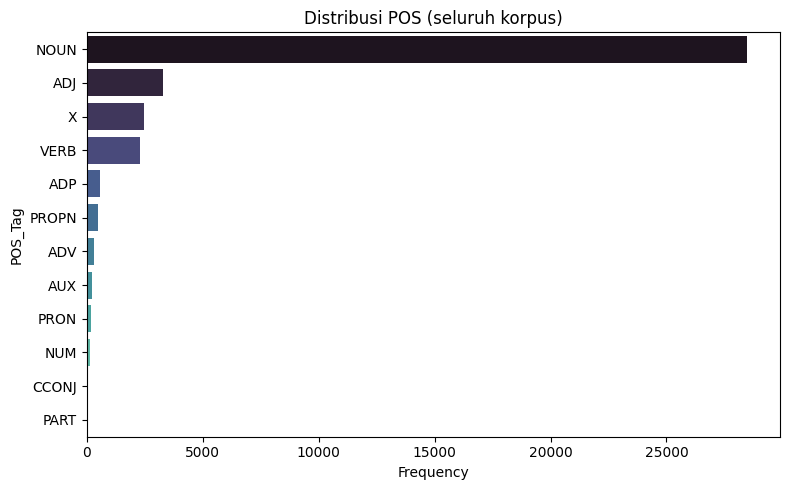

In [5]:
# hitung frekuensi POS di seluruh korpus
all_pos = []
for txt in df["text_for_pos"].dropna():
    all_pos.extend(pos_tags_from_text(txt))

pos_counts = Counter(all_pos)
df_pos_freq = pd.DataFrame(pos_counts.most_common(), columns=["POS_Tag", "Frequency"])
display(df_pos_freq)

# plot top POS
plt.figure(figsize=(8,5))
sns.barplot(data=df_pos_freq.head(12), x="Frequency", y="POS_Tag", palette="mako")
plt.title("Distribusi POS (seluruh korpus)")
plt.tight_layout()
plt.show()


In [6]:
from collections import Counter
import pandas as pd

def analyze_pos_overall(df, target_pos=["NOUN", "VERB", "ADJ", "PROPN"], top_k=10):
    """
    Menghasilkan ringkasan POS keseluruhan:
    POS_Tag | Total Frequency | Top 10 Words (Frequency)
    """
    pos_word_counts = {p: Counter() for p in target_pos}

    print("🔍 Memulai analisis POS untuk seluruh teks ...")

    # Loop semua teks
    for text in df["text_for_pos"].dropna():
        doc = nlp(text)
        for sent in doc.sentences:
            for w in sent.words:
                if w.upos in target_pos:
                    pos_word_counts[w.upos][w.text.lower()] += 1

    # Susun hasil ke DataFrame
    results = []
    for pos_tag, counter in pos_word_counts.items():
        total_freq = sum(counter.values())
        if total_freq == 0:
            continue

        # Ambil kata teratas per POS
        top_words = counter.most_common(top_k)
        formatted_top = "; ".join([f"{w} ({c})" for w, c in top_words])

        results.append({
            "POS_Tag": pos_tag,
            "Total Frequency": total_freq,
            "Top 10 Words (Frequency)": formatted_top
        })

    # Hasil akhir
    df_summary = pd.DataFrame(results)
    df_summary = df_summary.sort_values("POS_Tag").reset_index(drop=True)
    return df_summary

# --- Jalankan analisis ---
df_pos_summary = analyze_pos_overall(df)

# --- Tampilkan hasil ---
with pd.option_context('display.max_colwidth', None):
    display(df_pos_summary)

# --- Simpan hasil ---
df_pos_summary.to_excel("pos_summary_overall.xlsx", index=False)
df_pos_summary.to_csv("pos_summary_overall.csv", index=False)


🔍 Memulai analisis POS untuk seluruh teks ...


,POS_Tag,Total Frequency,Top 10 Words (Frequency)
0,ADJ,3303,online (429); salah (102); dasar (95); utama (66); langsung (66); aman (63); resmi (60); cepat (59); adil (55); bijak (52)
1,NOUN,28475,pengemudi (653); tarif (595); mitra (533); ojol (516); aplikasi (457); ojek (453); kerja (417); usaha (324); persen (308); driver (299)
2,PROPN,474,depok (17); malaysia (15); semarang (14); muhammad (11); sumatera (9); sulawesi (9); driver (9); goto (9); singapura (9); news (8)
3,VERB,2302,naik (365); turun (112); butuh (90); atur (63); masuk (63); lanjut (53); sebut (52); baca (45); tambah (42); buka (41)


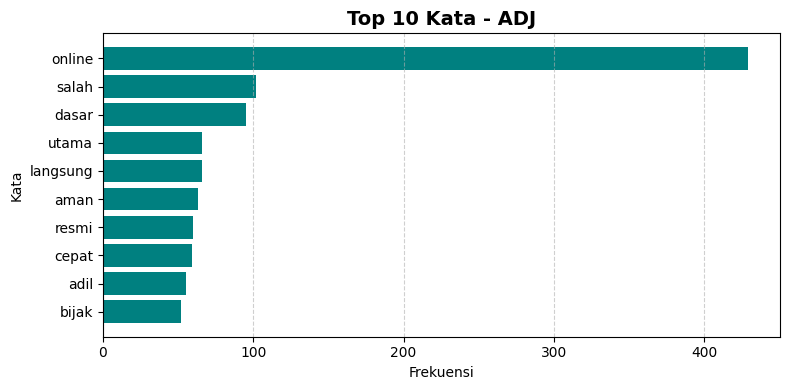

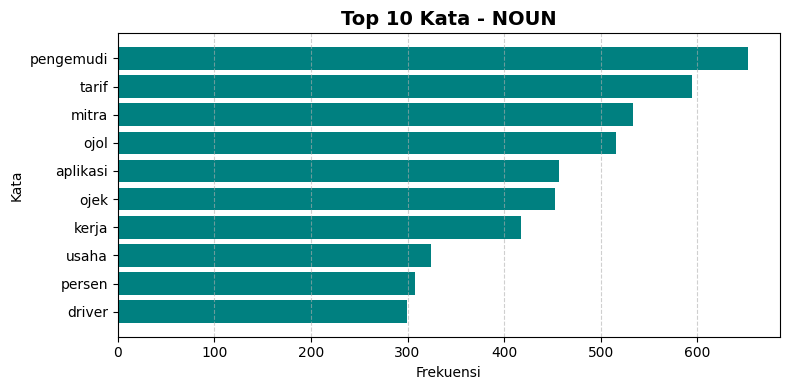

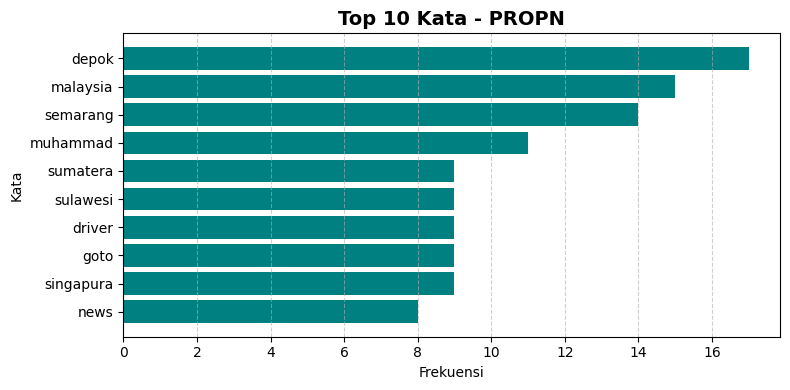

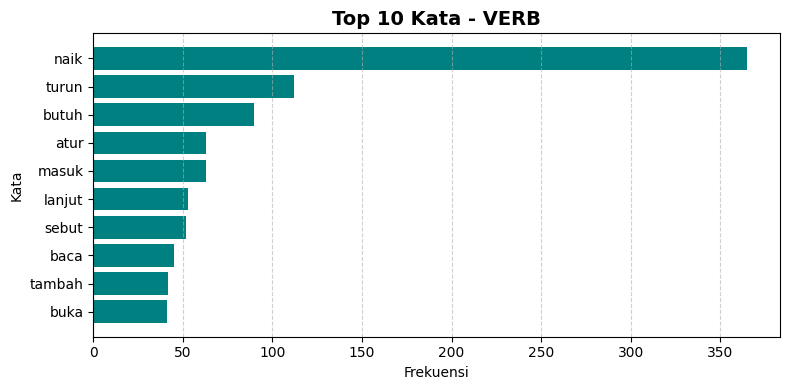

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_top_words_per_pos(df_pos_summary):
    """
    Membuat visualisasi bar chart untuk top 10 kata pada setiap POS_Tag.
    df_pos_summary harus berisi kolom:
    ['POS_Tag', 'Top 10 Words (Frequency)']
    """
    plt.style.use("seaborn-v0_8-muted")

    for _, row in df_pos_summary.iterrows():
        pos_tag = row["POS_Tag"]
        top_words = row["Top 10 Words (Frequency)"]

        # Pisahkan pasangan kata (frequency)
        words, counts = [], []
        for item in top_words.split("; "):
            try:
                word, freq = item.rsplit(" (", 1)
                words.append(word.strip())
                counts.append(int(freq.replace(")", "")))
            except:
                continue

        # Lewati jika kosong
        if not words:
            continue

        # Plot bar chart
        plt.figure(figsize=(8, 4))
        plt.barh(words[::-1], counts[::-1], color="teal")
        plt.title(f"Top 10 Kata - {pos_tag}", fontsize=14, fontweight='bold')
        plt.xlabel("Frekuensi")
        plt.ylabel("Kata")
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

# --- Jalankan visualisasi ---
visualize_top_words_per_pos(df_pos_summary)